In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Задания к уроку 3

### 1. Задание:

Нарисуйте график функции:
y(x) = k∙cos(x – a) + b
для некоторых (2-3 различных) значений параметров k, a, b


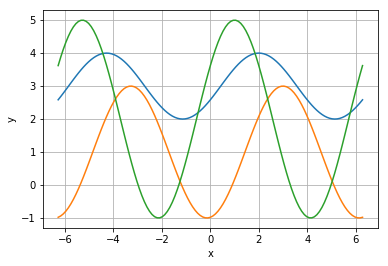

In [2]:
def y(k, a, b, x):
    return k * np.cos(x - a) + b

x = np.linspace(-2*np.pi, 2*np.pi, 121)
plt.plot(x, y(1, 2, 3, x))
plt.plot(x, y(2, 3, 1, x))
plt.plot(x, y(3, 1, 2, x))
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

### 2. Задание:

Докажите, что при ортогональном преобразовании сохраняется расстояние между точками

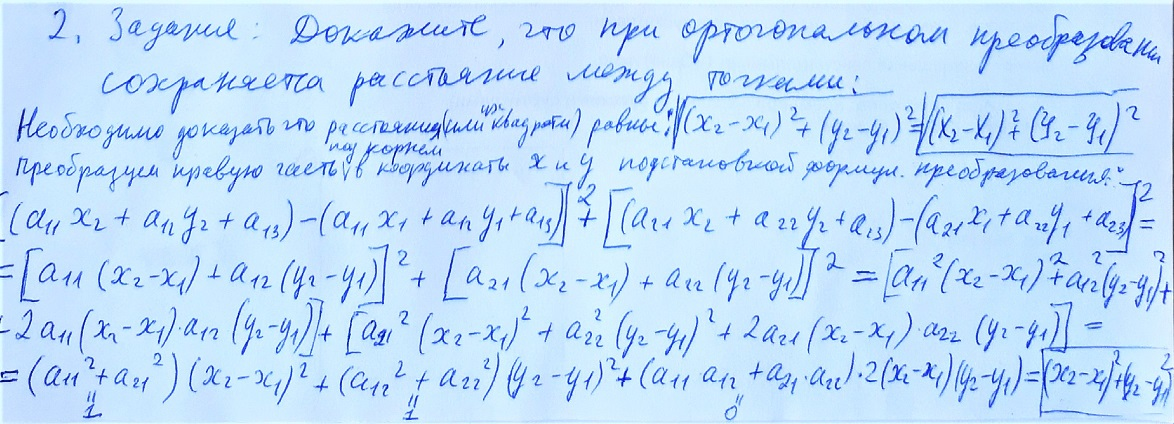

### 3. Задание:

1) Напишите код, который будет переводить полярные координаты в декартовы.

In [3]:
def pol2dec(r, alf):
    x = r * np.cos(alf)
    y = r * np.sin(alf)
    return x, y

r = 2
alf = np.pi / 6
x, y = pol2dec(r, alf)
x , y

(1.7320508075688774, 0.9999999999999999)

2) Напишите код, который будет рисовать график окружности в полярных координатах.

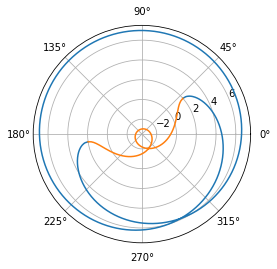

In [4]:
# Вариант 1 (график окружности, нарисованный в полярных координатах без преобразовния координат)
x = []
y1 = []
y2 = []
r = 5
x0 = 2
y0 = 2
for i in range((-r + x0)*100, (r + x0)*100 + 1):
    x_ = i/100
    x.append(x_)
    y1.append(y0 + np.sqrt(r**2 - (x_-x0)**2))
    y2.append(y0 -np.sqrt(r**2 - (x_-x0)**2))
plt.polar(x, y1)
plt.polar(x, y2)
plt.show()

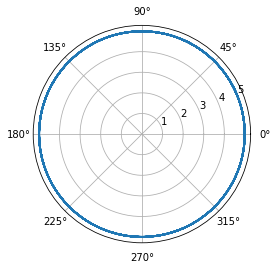

In [5]:
# Вариант 2 (график окружности, нарисованной в полярных координатах после преобразования координат из декартовых)
def dec2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    alf = np.arctan2(y, x) * 180 / np.pi
    return r, alf

r = 5
alf = np.linspace(0, np.pi, 1000)
x, y = pol2dec(r, alf)
r, alf = dec2pol(x, y) 
plt.polar(alf, r)
plt.show()

### 4. Задание:

1) Решите систему уравнений:
$$y=x^2-1$$
$$e^x+x(1-y)=1$$

Для решения системы выразим $y$ через $x$ во втором уравнении $y = 1-\frac{1-e^x}{x}$ и построим графики полученных функций $y(x)$:

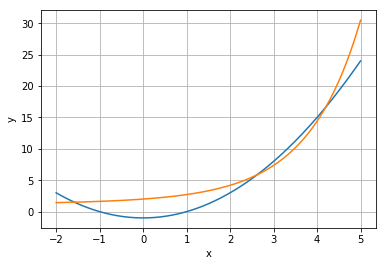

In [6]:
x = np.linspace(-2, 5, 201)
plt.plot(x, x**2 - 1)
plt.plot(x, 1 - (1 - np.exp(x)) / x)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

Решением системы уравнений будут точки пересечения построенных графиков функций $y(x)$ плюс случай когда $x=0$ (случай деления на 0 во второй функции $y(x)$), корни найдем через численные методы numpy с предварительным указанием приблизительных координат точек пересечений графиков:

In [7]:
from scipy.optimize import fsolve

def equations(p):
    x, y = p
    return (y - x**2 + 1, np.exp(x) + x*(1 - y) - 1)

x1, y1 = fsolve(equations, (-2, 2))
print('x1={}, y1={}'.format(x1, y1))

x2, y2 = fsolve(equations, (3, 6))
print('x2={}, y2={}'.format(x2, y2))

x3, y3 = fsolve(equations, (4, 17))
print('x3={}, y3={}'.format(x3, y3))

x4, y4 = fsolve(equations, (0, -1))
print('x4={}, y4={}'.format(x4, y4))

x1=-1.5818353528958982, y1=1.5022030836712916
x2=2.618145573086073, y2=5.8546862418707315
x3=4.200105841106243, y3=16.640889076512234
x4=0.0, y4=-1.0


2) Решите систему уравнений и неравенств:
$$y=x^2-1$$
$$e^x+x(1-y)>1$$

Для решения системы подставим $y$ из уравнения в неравенство и перенесем в неравенстве всё в левую часть чтобы получить в правой части $>0$, а так же построим график функции из полученной левой части неравенства в результате $f(x)=e^x+x(2-x^2)-1$:

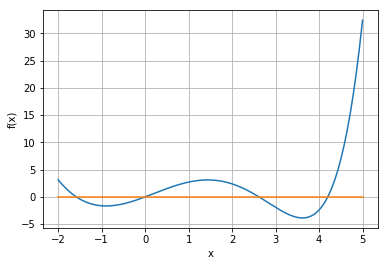

In [8]:
x = np.linspace(-2, 5, 201)
plt.plot(x, np.exp(x) + x*(2 - x**2) - 1)
plt.plot([-2, 5], [0, 0])
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

Решением системы уравнения и неравенства будут области где $f(x) > 0$ для построенной функции $f(x)=e^x+x(2-x^2)-1$, после нахождения корней численными методами в точках пересечения с осью $x$ (где $y=0$) можем получить диапазоны решения для $x$, а для $y$ решением будут все значения, вычисленные по формуле $y=x^2-1$ для всех $x$ из этих диапозонов:

In [9]:
from scipy.optimize import fsolve

def equations(p):
    x = p
    return np.exp(x) + x * (2 - x**2) - 1

x1 = fsolve(equations, -2)
x2 = fsolve(equations, 0)
x3 = fsolve(equations, 3)
x4 = fsolve(equations, 4)
print('1-я область решения лежит в диапозоне x от минус бесконечности до x1={}, не включая x1'.format(x1))
print('2-я область решения лежит в диапозоне x от x2={} до x3={}, не включая x2 и x3'.format(x2, x3))
print('3-я область решения лежит в диапозоне x от x4={} до плюс бесконечности, не включая x4'.format(x4))

1-я область решения лежит в диапозоне x от минус бесконечности до x1=[-1.58183535], не включая x1
2-я область решения лежит в диапозоне x от x2=[0.] до x3=[2.61814557], не включая x2 и x3
3-я область решения лежит в диапозоне x от x4=[4.20010584] до плюс бесконечности, не включая x4


# Задания к уроку 4

### 1. Задание:

Напишите код, моделирующий выпадение поля в рулетке (с учетом поля зеро).

In [10]:
for i in range(0, 10):
    a = input()
    x = int(np.random.uniform(0, 37))
    print("Выпало поле: {}".format(x))



Выпало поле: 12

Выпало поле: 29

Выпало поле: 17

Выпало поле: 7

Выпало поле: 34

Выпало поле: 5

Выпало поле: 29

Выпало поле: 10

Выпало поле: 23

Выпало поле: 4


### 2. Задание:

1) Напишите код, проверяющий любую из теорем сложения или умножения вероятности на примере подбрасывания монетки.

In [11]:
k,m = 0, 0
n = 100
for i in range(0, n):
    x = np.random.uniform(0, 10)
    if x<5:
#        print("орел")
        k = k + 1
    else:
#        print("решка")
        m = m + 1

p_k = k/(k+m)
p_m = m/(k+m)
p_km = 0 #вероятность выпадения одновременно "орла" и "решки"
p_sum = p_k + p_m
p_mult = p_k * p_km
print('Вероятность для "орла": {}'.format(p_k))
print('Вероятность для "решки": {}'.format(p_m))
print('Сумма вероятностей "орла" и "решки": {}'.format(p_sum))
print('Произведение вероятностей "орла" и "решки": {}'.format(p_mult))

Вероятность для "орла": 0.55
Вероятность для "решки": 0.45
Сумма вероятностей "орла" и "решки": 1.0
Произведение вероятностей "орла" и "решки": 0.0


2) Сгенерируйте десять выборок случайных чисел х0, …, х9.
и постройте гистограмму распределения случайной суммы х0+х1+ …+ х9.

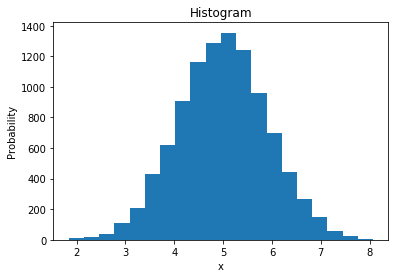

In [12]:
k, n = 10, 10000
x = np.array([np.random.rand(k).sum() for _ in range(n)])
# print(x)
num_bins = 20
n, bins, patches = plt.hist(x, num_bins)
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Histogram')
plt.show()

### 3. Задание:

1) Дополните код Монте-Карло последовательности независимых испытаний расчетом соответствующих вероятностей (через биномиальное распределение) 
и сравните результаты.

In [13]:
k, n = 0, 10000
a = np.random.randint(0, 2, n)
b = np.random.randint(0, 2, n)
c = np.random.randint(0, 2, n)
d = np.random.randint(0, 2, n)
x = a + b + c + d
for i in range(0, n):
    if x[i] == 2:
        k = k + 1
print(k, n, k/n)

3749 10000 0.3749


In [14]:
import math
k, n = 2, 4
c_k_n = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
p_k_n = c_k_n / (2**n) # для монеты
print(c_k_n, p_k_n)

6.0 0.375


Результаты расчета вероятности по коду Монте-Карло и по формуле близки и равны ~ 0.375

2) Повторите расчеты, взяв другие значения n и k.

In [15]:
k, n = 4, 8
c_k_n = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
p_k_n = c_k_n / (2**n) # для монеты
print(c_k_n, p_k_n)

70.0 0.2734375


### 4. Задание:

Повторите расчеты, взяв другие значения n и k.

In [17]:
import itertools
for p in itertools.product("01234",repeat=2):
    print(''.join(p))  

00
01
02
03
04
10
11
12
13
14
20
21
22
23
24
30
31
32
33
34
40
41
42
43
44


In [18]:
for p in itertools.permutations("01234",3):
    print(''.join(str(x) for x in p))

012
013
014
021
023
024
031
032
034
041
042
043
102
103
104
120
123
124
130
132
134
140
142
143
201
203
204
210
213
214
230
231
234
240
241
243
301
302
304
310
312
314
320
321
324
340
341
342
401
402
403
410
412
413
420
421
423
430
431
432


In [19]:
for p in itertools.combinations("01234",3):
    print(''.join(p))

012
013
014
023
024
034
123
124
134
234


### 5. Задание:

Дополните код расчетом коэффициента корреляции x и y по формуле:
$$R=\frac{\sum(x_i-x_m)(y_i-y_m)}{\sqrt{\sum(x_i - x_m)^2\sum(y_i - y_m)^2}}$$

C:\Users\Ne0\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


0.7121834148479083 0.14383272667717795 0.9162310530246387
0.7121834148479091 0.14383272667717803 0.9162310530246386


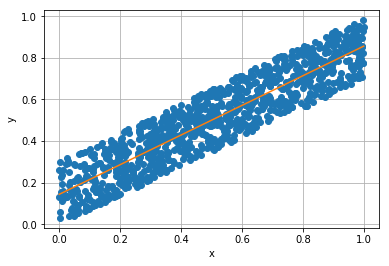

In [20]:
n = 1000
r = 0.7
x = np.random.rand(n)
y = r*x + (1 - r)*np.random.rand(n)
plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

a = (np.sum(x)*np.sum(y) - n*np.sum(x*y))/(np.sum(x)*np.sum(x) - n*np.sum(x*x))
b = (np.sum(y) - a*np.sum(x))/n
x_m = np.mean(x)
y_m = np.mean(y)
x_1 = x - x_m
y_1 = y - y_m
r = np.sum(x_1 * y_1) / np.sqrt(np.sum(x_1**2) * np.sum(y_1**2))

A = np.vstack([x, np.ones(len(x))]).T
a1, b1 = np.linalg.lstsq(A, y)[0]
r1 = np.corrcoef(x, y)[0,1]

print(a, b, r)
print(a1, b1, r1)

plt.plot([0, 1], [b, a + b])
plt.show()

### Доп. Задание:

Классическая задача про иглу Бюффона (решать методом Монте-Карло):
- Иголку длиной b=10 см наудачу бросают на разлинованную бумагу, где расстояние между соседними линиями тоже a=10 см.
- С какой вероятностью упавшая иголка пересечет линию бумаги?
- Сделать расчеты, взяв другие (неравные значения a и b)


In [21]:
k, n = 0, 1000000
a = 10
b = 10
y0 = a * np.random.random(n)
alf = np.pi * np.random.random(n)
y1 = y0 + b * np.sin(alf)
for i in range(0, n):
    if y1[i] > a:
        k = k + 1
print(k, n, k/n, '<-вероятность')

637404 1000000 0.637404 <-вероятность


In [22]:
k, n = 0, 1000000
a = 10
b = 5
y0 = a * np.random.random(n)
alf = np.pi * np.random.random(n)
y1 = y0 + b * np.sin(alf)
for i in range(0, n):
    if y1[i] > a:
        k = k + 1
print(k, n, k/n, '<-вероятность')

317716 1000000 0.317716 <-вероятность
